In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle
import os
import gc
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import json
from tqdm.notebook import tqdm

from utilities import (
    RANDOM_STATE, TARGET_COL, N_FOLD, FOLD_STRAT_NAME,
)

INPUT_PATH = '../input/tabular-playground-series-oct-2021'
PATH_NOTEBOOK = '../input/preprocess-gpu'
PATH_PARAM = '../input/optuna-lightgbm'

TEST_PATH = [
#     '../input/xgboost-tuned',
    '../input/lightgbm-tuned',
#     '../input/catboost-benchmark',
#     '../input/nn-cat-binned',
]

In [2]:
with open(os.path.join(PATH_NOTEBOOK, 'feature_dic.pkl'), 'rb') as file:
    feature_dic = pickle.load(file)

#CONSTANT
FEATURE = feature_dic['feature']
CAT_COL = feature_dic['categorical']
NUMERIC_COL = feature_dic['numerical']

In [3]:
train = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'train_unscaled.pkl')
)

In [4]:
test = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'test_unscaled.pkl')
)

In [5]:
for i, path in tqdm(enumerate(TEST_PATH)):

    sub = pd.read_csv(
        os.path.join(path, 'submission.csv')
    )
    
    sub['target_fold'] = (sub['target']>=.5).astype(int)

    #DEFINE FOLD same as PREPROCESS
    strat_fold = StratifiedKFold(n_splits = N_FOLD, random_state = RANDOM_STATE, shuffle = True)
    sub[FOLD_STRAT_NAME] = -1

    for j, (_, test_index) in enumerate(strat_fold.split(sub, sub['target_fold'])):
        sub.loc[test_index, FOLD_STRAT_NAME] = j

    pseudo_test = pd.concat([test, sub[[FOLD_STRAT_NAME, 'target']]], axis = 1)
    train = pd.concat([train, pseudo_test], axis = 0)

    gc.collect()

0it [00:00, ?it/s]

In [6]:
del test

In [7]:
train.reset_index(drop = True, inplace = True)

In [8]:
FOLD_LIST = list(range(train[FOLD_STRAT_NAME].nunique()))

gc.collect()

83

# TRAIN

In [9]:
params = {
    'objective': 'xentropy',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'random_state': RANDOM_STATE,
    'verbose': -1,
    'n_jobs': -1,
    'device_type': 'gpu',
}

#import lgb optimized parameter (file_name is wrong :()

with open(os.path.join(PATH_PARAM, 'final_xgb_param.pkl'), 'rb') as file:
    param_lgb_final = pickle.load(file)
    
params.update(param_lgb_final)

#pretty print
print(json.dumps(params, indent=4))

{
    "objective": "xentropy",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "random_state": 383920,
    "verbose": -1,
    "n_jobs": -1,
    "device_type": "gpu",
    "num_leaves": 108,
    "bagging_fraction": 0.9826419035313325,
    "bagging_freq": 3,
    "feature_fraction": 0.4391703923164765,
    "lambda_l1": 9.981933259825583,
    "lambda_l2": 4.787223416853744,
    "min_data_in_leaf": 47,
    "extra_trees": true,
    "min_gain_to_split": 1.3870747701430455,
    "path_smooth": 1.6530551435631298
}


In [10]:
score = 0
model_list = []

for i, fold_ in enumerate(FOLD_LIST):

    mask_train = (train[FOLD_STRAT_NAME] != fold_)
    mask_test = (train[FOLD_STRAT_NAME] == fold_)
    
    
    train_x, train_y = train.loc[mask_train, FEATURE], train.loc[mask_train, TARGET_COL]
    test_x, test_y = train.loc[mask_test, FEATURE], train.loc[mask_test, TARGET_COL]

    model = lgb.train(
        params,
        lgb.Dataset(train_x, label=train_y,categorical_feature=CAT_COL), 30000,
        valid_sets = lgb.Dataset(test_x, label=test_y,categorical_feature=CAT_COL),
        valid_names ='validation', verbose_eval=100, early_stopping_rounds = 100,
    )
        
    #evaluate score and save model for importance/prediction
    score_fold = model.best_score['validation']['cross_entropy'] 
    score += score_fold/N_FOLD
    
    model_list.append(model)
    
    print('\nFold: {}; Cross Entropy: {:.5f}\n'.format(fold_, score_fold))
    print('-'*50)
    print('\n\n\n')
    gc.collect()
    
print('CV-Cross Entropy: {:.5f}\n'.format(score))

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	validation's cross_entropy: 0.593571
[200]	validation's cross_entropy: 0.546517
[300]	validation's cross_entropy: 0.525387
[400]	validation's cross_entropy: 0.511004
[500]	validation's cross_entropy: 0.501219
[600]	validation's cross_entropy: 0.495847
[700]	validation's cross_entropy: 0.49193
[800]	validation's cross_entropy: 0.488889
[900]	validation's cross_entropy: 0.486536
[1000]	validation's cross_entropy: 0.484586
[1100]	validation's cross_entropy: 0.483023
[1200]	validation's cross_entropy: 0.481712
[1300]	validation's cross_entropy: 0.480583
[1400]	validation's cross_entropy: 0.479588
[1500]	validation's cross_entropy: 0.478685
[1600]	validation's cross_entropy: 0.477912
[1700]	validation's cross_entropy: 0.477232
[1800]	validation's cross_entropy: 0.476614
[1900]	validation's cross_entropy: 0.476061
[2000]	validation's cross_entropy: 0.475581
[2100]	validation's cross_entropy: 0.47513
[2200]	validation's cross

# Feature importance

In [11]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = FEATURE


for fold_, model in enumerate(model_list):
    feature_importances['fold_{}'.format(fold_ + 1)] = model.feature_importance(importance_type='gain')

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

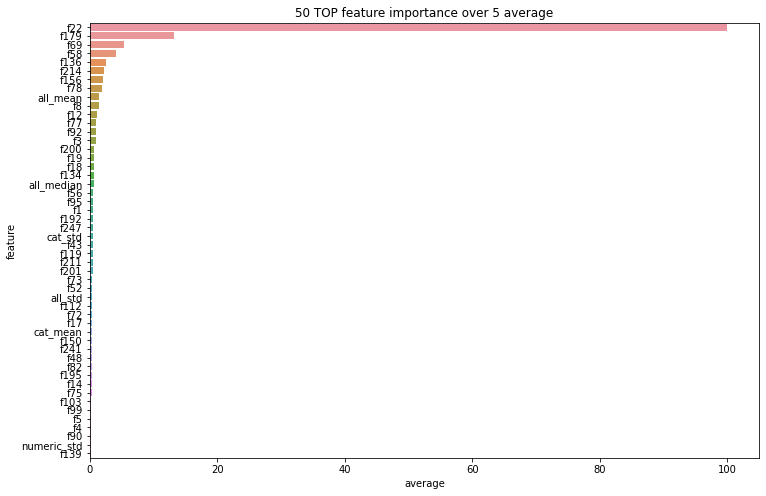

In [12]:
scaler = MinMaxScaler(feature_range=(0, 100))

average_importance = feature_importances.drop('feature', axis = 1).mean(axis=1)

feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(average_importance))
feature_importances = feature_importances.sort_values(by='average', ascending=False)

feature_importances[['feature', 'average']].to_csv('feature_importances.csv',index=False)

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.head(50), x='average', y='feature');
plt.title(f'50 TOP feature importance over {N_FOLD} average')

In [13]:
del train
gc.collect()

31

# TEST Blending

In [14]:
test = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'test_unscaled.pkl')
)

In [15]:
pred_test = np.zeros(test.shape[0])

for fold_, model in enumerate(model_list):
    pred_test += model.predict(test)/N_FOLD

# SAVE RESULT

In [16]:
submission = pd.read_csv(os.path.join(INPUT_PATH, 'sample_submission.csv'))
submission['target'] = pred_test

submission.to_csv('submission.csv', index = False)